# Importing libraries and necessary modules

In [104]:
!pip install PyDrive
!pip install gensim

In [105]:
import re
import csv
import nltk
import keras
import random
import gensim
import numpy as np
import pandas as pd
nltk.download('punkt')
from pprint import pprint
from gensim import corpora
from google.colab import auth
import matplotlib.pyplot as plt
from keras.datasets import mnist
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from pydrive.auth import GoogleAuth
from keras.models import Sequential
from pydrive.drive import GoogleDrive
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding 
from keras.preprocessing.text import Tokenizer
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, LancasterStemmer
from keras.layers.core import Dense, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.mixture import GaussianMixture
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import DBSCAN, AffinityPropagation, AgglomerativeClustering, Birch
from sklearn.cluster import OPTICS, DBSCAN, MiniBatchKMeans, MeanShift, SpectralClustering

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
''' Authenticate and create the PyDrive client to mount data from google drive'''

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [107]:
''' 
sharbale link for the file that contains dataset and existed on google drive
the id of that link will be used to download the file
https://drive.google.com/file/d/1ZbbvBlVPXLemTQ173CR4OwKA95ewdRzl/view?usp=sharing
 '''

downloaded = drive.CreateFile({'id':"1ZbbvBlVPXLemTQ173CR4OwKA95ewdRzl"})
downloaded.GetContentFile('vaccination_all_tweets.csv')

# Data preprocessing

In [108]:
data = pd.read_csv('vaccination_all_tweets.csv')
data.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [109]:
''' 
find if there is any nan data in dataset
if some features be nan it could be a sign of bot 
not a real user as the owner of tweet, such as username
'''

data.isna().sum()

id                      0
user_name               1
user_location       62740
user_description    15406
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            47194
source                119
retweets                0
favorites               0
is_retweet              0
dtype: int64

In [110]:
'''
username and source should not be nan, 
so the data row containing nan value in these feature will be droped
'''

data = data.dropna(subset=['user_name', 'source'])
data.isna().sum()

id                      0
user_name               0
user_location       62631
user_description    15406
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            47121
source                  0
retweets                0
favorites               0
is_retweet              0
dtype: int64

In [111]:
'''
check whether the creation date of account is later that the creation 
date of the tweet, if so, the owner of account is bot
'''

data['date'] = pd.to_datetime(data['date'])
data['user_created'] = pd.to_datetime(data['user_created'])
# print(data.iloc[0]['date'] - data.iloc[0]['user_created'])
data.where(data.user_created > data.date).sum()

id                  0.0
user_name           0.0
user_location       0.0
user_description    0.0
user_followers      0.0
user_friends        0.0
user_favourites     0.0
user_verified       0.0
text                0.0
hashtags            0.0
source              0.0
retweets            0.0
favorites           0.0
is_retweet          0.0
dtype: float64

## Text/ tweet analysis

In [112]:
'''Remove URLs, Hashtags, single quotes, emails, new lines, mentiones, convert to low case'''

def clean_tweet_text(data):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    data = re.sub('\S*@\S*\s?', '', data)
    data = re.sub('\s+', ' ', data)
    data = re.sub("\'", "", data)
    data = re.sub(r'@\w+', '', data)
    data = re.sub(r'#', '', data)
    data = re.sub(r'RT[\s]+', '', data)
    data = data.lower()    
    return data

cleaned_txt = []
data_to_list = data['text'].values.tolist()
for i in range(len(data_to_list)):
    cleaned_txt.append(clean_tweet_text(data_to_list[i]))

In [113]:
'''Remove punctuations from text'''

def remove_punctuations(sentences):
    clean_sentences = []
    for sentence in sentences:
      tokens = word_tokenize(sentence)
      words = [word for word in tokens if word.isalpha()]
      clean_sentences.append(words)
    return clean_sentences

data_words = remove_punctuations(cleaned_txt)

In [114]:
''' Remove stopwords from text'''

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
print("Stop words are: \n", stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stop words are: 
 {'hers', 'nor', 'he', 'more', 'to', 'then', 'and', 'is', "don't", 'aren', 'shan', 'after', 'when', "you're", 'up', 'off', 'at', "shouldn't", 'down', "that'll", "hasn't", "it's", 'about', "couldn't", 'wasn', 'your', 'against', 'll', 'own', 'during', 'below', 'hadn', 'wouldn', 'while', 'am', 'an', 'any', 'won', 'not', "won't", 'again', 'for', 'needn', 'him', "you'll", "you'd", 'i', 's', 'will', 'should', 'my', 're', "shan't", 'haven', 'before', 'which', 'y', "you've", 'them', 'ourselves', 'doing', 'out', 've', 'our', "didn't", 'ain', 'mustn', 'here', 'has', 'o', "mustn't", 'hasn', 'until', 'as', 'a', "mightn't", 'where', 'been', 'but', 'only', 'shouldn', 'were', "aren't", 'm', 'same', 'does', 'than', 'above', 'me', 'now', 'do', "doesn't", 'too', "isn't", 'was', 'some', "wasn't", 'don', 'having', 'themselves', "weren't", 'she', 'if', 'very', 'into', 'her

In [115]:
def Remove_stopwords(data):
  temp_list = []
  for sentence in data:
    temp_sentence = []
    for word in sentence:
      if(word not in stop_words):
        temp_sentence.append(word)

    temp_list.append(temp_sentence)
  return temp_list

removed_stopword = Remove_stopwords(data_words)

In [116]:
''' 
Stemming the words, convert each word to its root
for instance convert hopfully --> hope
'''

porter=PorterStemmer()

def stem_sentence(without_stopwords):
  stem_sentences = []
  for sentence in without_stopwords:
    stem_sen=[]
    for word in sentence:
      stem_sen.append(porter.stem(word))
    stem_sentences.append(stem_sen)
  return stem_sentences

stem_words = stem_sentence(removed_stopword)

In [117]:
'''make sentences of each tweet and add the cleaned text as a column to dataset'''
sentences = []
for sent in stem_words:
  sentences.append(" ".join(sent))

data['cleaned_txt'] = sentences
data.to_csv("vaccination_all_tweets_v2.csv")
print(data['cleaned_txt'])  

0         folk said daikon past could treat cytokin stor...
1         world wrong side histori year hope biggest vac...
2         coronaviru sputnikv astrazeneca pfizerbiontech...
3         fact immut senat even your ethic sturdi enough...
4               explain need vaccin whereareallthesickpeopl
                                ...                        
212977    bbmp bengaluru covidvaccin avail free slot cov...
212978    bbmp bengaluru covidvaccin avail free slot cov...
212979    sell nitrileglov facemask vaccin sputnikv syri...
212980    urban bengaluru covidvaccin avail free slot pa...
212981    urban bengaluru covidvaccin avail free slot pa...
Name: cleaned_txt, Length: 212862, dtype: object


#Sentence embedding- method 1: Doc2Vec

In [118]:
'''we define a function which returns the cosine similarity between 2 vectors'''
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

'''tagged_data'''
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(stem_words)]

In [119]:
embed_model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

'\nvector_size = Dimensionality of the feature vectors.\nwindow = The maximum distance between the current and predicted word within a sentence.\nmin_count = Ignores all words with total frequency lower than this.\nalpha = The initial learning rate.\n'

In [120]:
with open('test.npy', 'wb') as f:
  for i in range(len(embed_model.docvecs)):
      np.save(f, embed_model.docvecs[i])
    # np.save(f, np.array([1, 3]))
# print(model.docvecs[i])

## Dimension reduction method: PCA

In [121]:
input_sample = []
for i in range(len(embed_model.docvecs)):
  input_sample.append((embed_model.docvecs[i]).tolist())

In [122]:
N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(input_sample)
pca.explained_variance_ratio_


array([0.07634824, 0.07249137, 0.06936809, 0.06613397, 0.06270494,
       0.06066036, 0.05837979, 0.05531343, 0.05343841, 0.05242243])

##Clustering methods: K-Means

In [123]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)
pred_kmeans = kmeans.fit_predict(X_pca)

In [ ]:
predicted_labels_v1 = pred_kmeans.tolist()
for i in range(len(predicted_labels_v1)):
  if i < 5000:
   print(i + 1, " = ", predicted_labels_v1[i])
  else:
    break

(-1.0, 2.0)

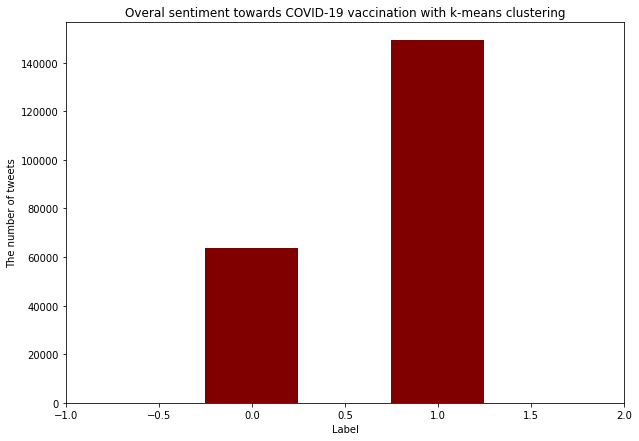

In [125]:
count0 = count1 = 0 
for num in predicted_labels_v1:
  if num == 0:
    count0 += 1
  if num == 1:
    count1 += 1

fig = plt.figure(figsize = (10, 7))
plt.bar([0, 1], [count0, count1], color ='maroon', width = 0.5)
plt.title("Overal sentiment towards COVID-19 vaccination with k-means clustering")
plt.xlabel("Label")
plt.ylabel("The number of tweets")
plt.xlim([-1, 2])

##Clustering method: Mini batch K-Means

In [126]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters=2).fit(X_pca)
# fit the model
# model.fit(X)
# assign a cluster to each example
# yhat = model.predict(X)
pre_labels_v2 = mini_batch_kmeans.labels_
pred_labels_v2 = pre_labels_v2.tolist()

In [ ]:
for i in range(len(pred_labels_v2)):
  if i < 5000:
   print(i + 1, " = ", pred_labels_v2[i])
  else:
    break

(-1.0, 2.0)

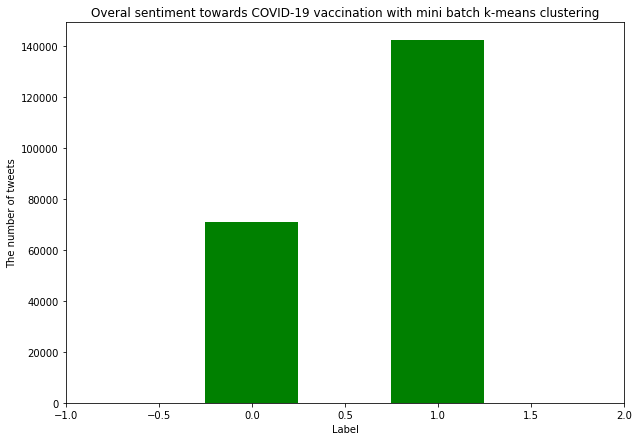

In [128]:
count0 = count1 = 0 
for num in pred_labels_v2:
  if num == 0:
    count0 += 1
  if num == 1:
    count1 += 1

fig = plt.figure(figsize = (10, 7))
plt.bar([0, 1], [count0, count1], color ='green', width = 0.5 )
plt.title("Overal sentiment towards COVID-19 vaccination with mini batch k-means clustering")
plt.xlabel("Label")
plt.ylabel("The number of tweets")
plt.xlim([-1, 2])

  ## Write the result in a file

In [129]:
f = open('Embedding_Clusting_out.csv', 'w')

# create the csv writer
writer = csv.writer(f)
# write a row to the csv file
writer.writerow(['Index', 'Doc2Vec_kMeans', 'mini_batch_kMean', 'Doc2Vec'])
for i in range(len(predicted_labels)):

  writer.writerow([i, predicted_labels_v1[i], pred_labels_v2[i], input_sample[i]])
# close the file
f.close()

## LSTM network for prediction

### Data prepration

In [130]:
generated_data = pd.read_csv("Embedding_Clusting_out.csv")
print("Number of rows in the second dataset generated is : ", len(generated_data))

Number of rows in the second dataset generated is :  212862


In [131]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
data['cleaned_txt'] = data['cleaned_txt'].astype(str)
tokenizer.fit_on_texts(data['cleaned_txt'].values)
X = tokenizer.texts_to_sequences(data['cleaned_txt'].values)
X = pad_sequences(X)

In [132]:
Y = pd.get_dummies(generated_data['Doc2Vec_kMeans']).values

# print(X.shape)
# print(Y.shape, "\n")
'''split the test and train data'''
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 42572, random_state=0)


In [133]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(170290, 20) (170290, 2)
(42572, 20) (42572, 2)


### LSTM architecture

In [134]:
# # The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 30
# This is fixed.
EMBEDDING_DIM = 128
def LSTM_model(input_data, MAX_NB_WORDS, EMBEDDING_DIM):
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length= input_data.shape[1]))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model


In [136]:
epochs = 20
batch_size = 64
model_v1 = LSTM_model(X, MAX_NB_WORDS, EMBEDDING_DIM)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 128)           6400000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 20, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 100)               91600     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 6,491,802
Trainable params: 6,491,802
Non-trainable params: 0
_________________________________________________________________
None


###LSTM for k-means labels

In [137]:
'''fit the network over the target labels predicted with k-means'''
history = model_v1.fit(X_train, Y_train, epochs=epochs, batch_size = 64, validation_data=[X_test, Y_test],
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
2661/2661 [==============================] - 313s 117ms/step - loss: 0.3154 - accuracy: 0.8595 - val_loss: 0.2737 - val_accuracy: 0.8798
Epoch 2/20
2661/2661 [==============================] - 309s 116ms/step - loss: 0.2709 - accuracy: 0.8812 - val_loss: 0.2671 - val_accuracy: 0.8840
Epoch 3/20
2661/2661 [==============================] - 309s 116ms/step - loss: 0.2605 - accuracy: 0.8861 - val_loss: 0.2641 - val_accuracy: 0.8860
Epoch 4/20
2661/2661 [==============================] - 308s 116ms/step - loss: 0.2534 - accuracy: 0.8896 - val_loss: 0.2593 - val_accuracy: 0.8887
Epoch 5/20
2661/2661 [==============================] - 307s 115ms/step - loss: 0.2474 - accuracy: 0.8927 - val_loss: 0.2666 - val_accuracy: 0.8864
Epoch 6/20
2661/2661 [==============================] - 308s 116ms/step - loss: 0.2415 - accuracy: 0.8951 - val_loss: 0.2580 - val_accuracy: 0.8883
Epoch 7/20
2661/2661 [==============================] - 308s 116ms/step - loss: 0.2373 - accuracy: 0.8971 - val_

In [139]:
score,acc = model_v1.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

666/666 - 6s - loss: 0.2601 - accuracy: 0.8905 - 6s/epoch - 8ms/step
score: 0.26
acc: 0.89


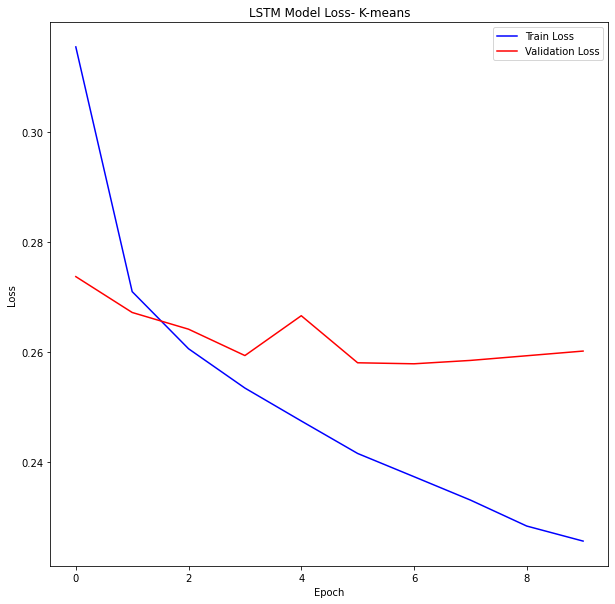

In [140]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'red')
plt.title("LSTM Model Loss- K-means")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()
# fig_Loss.savefig("Loss.png")

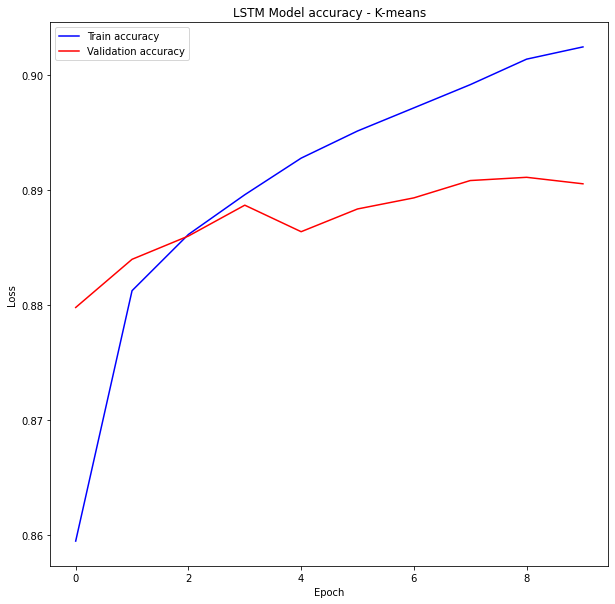

In [141]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'red')
plt.title("LSTM Model accuracy - K-means")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train accuracy","Validation accuracy"])
plt.show()

### LSTM for mini batch k-means labels

In [142]:
Y_mini_batch = pd.get_dummies(generated_data["mini_batch_kMean"]).values

# print(X.shape)
# print(Y.shape, "\n")
'''split the test and train data'''
X_train_v2, X_test_v2, Y_train_v2, Y_test_v2 = train_test_split(X, Y_mini_batch, test_size= 42572, random_state=0)

In [143]:
model_v2 = LSTM_model(X, MAX_NB_WORDS, EMBEDDING_DIM)
history_v2 = model_v2.fit(X_train_v2, Y_train_v2, epochs=epochs, batch_size = 64, validation_data=[X_test_v2, Y_test_v2],
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 128)           6400000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 20, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 100)               91600     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 6,491,802
Trainable params: 6,491,802
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2661/2661 [==============================] - 314s 117ms/step - loss: 0.3386 - accuracy: 0.8475

In [144]:
score_v2,acc_v2 = model_v2.evaluate(X_test_v2, Y_test_v2, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score_v2))
print("acc: %.2f" % (acc_v2))

666/666 - 6s - loss: 0.2711 - accuracy: 0.8820 - 6s/epoch - 9ms/step
score: 0.27
acc: 0.88


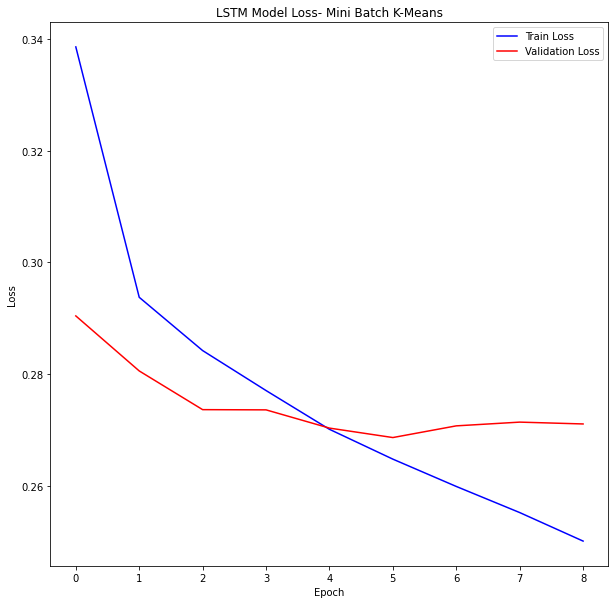

In [145]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(history_v2.history["loss"], color = 'blue')
plt.plot(history_v2.history["val_loss"], color = 'red')
plt.title("LSTM Model Loss- Mini Batch K-Means")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()
# fig_Loss.savefig("Loss.png")

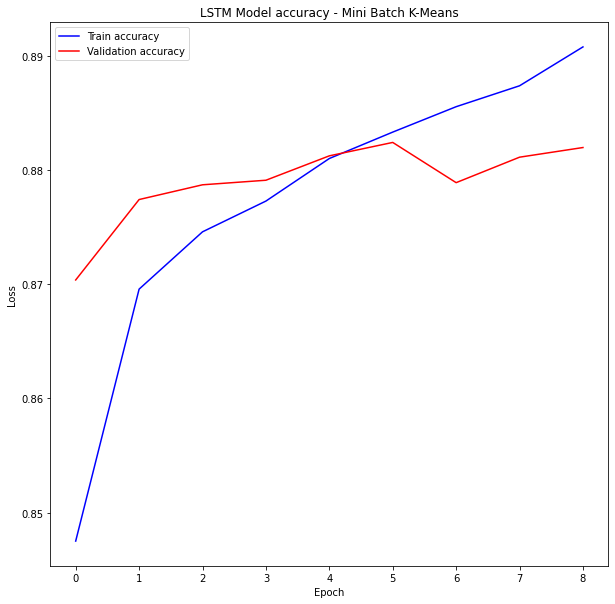

In [146]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(history_v2.history["accuracy"], color = 'blue')
plt.plot(history_v2.history["val_accuracy"], color = 'red')
plt.title("LSTM Model accuracy - Mini Batch K-Means")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train accuracy","Validation accuracy"])
plt.show()

## Negative tweets clustering

### collect negative tweets

In [147]:
negative_embeddings = []
for i in range(len(predicted_labels)):
  if predicted_labels[i] == 0:
    negative_embeddings.append((embed_model.docvecs[i]).tolist())


###Dimension reduction

In [148]:
N_COMPONENTS = 9
pca_neg = PCA(n_components=N_COMPONENTS)
X_neg = pca_neg.fit_transform(negative_embeddings)
pca_neg.explained_variance_ratio_

array([0.07909153, 0.07627274, 0.06822508, 0.06684175, 0.0651759 ,
       0.06164853, 0.05903839, 0.05535605, 0.05406013])

### Clustering method: DBSCAN

In [149]:
dbscan = DBSCAN(eps=0.30, min_samples= 13).fit(X_neg)
# fit model and predict clusters
# pred_dbscan = dbscan.fit_predict(X_neg)

In [150]:
from numpy import unique
clusters = unique(dbscan)
# print(clusters)
labels = dbscan.labels_
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 24
Estimated no. of noise points: 61465


### Clustering method: k-means

In [151]:
kmeans_neg = KMeans(n_clusters= 3, random_state = 0)
pred_kmeans_neg = kmeans_neg.fit_predict(X_neg)
pred_neg_labels2 = pred_kmeans_neg.tolist()

Text(0, 0.5, 'The number of tweets')

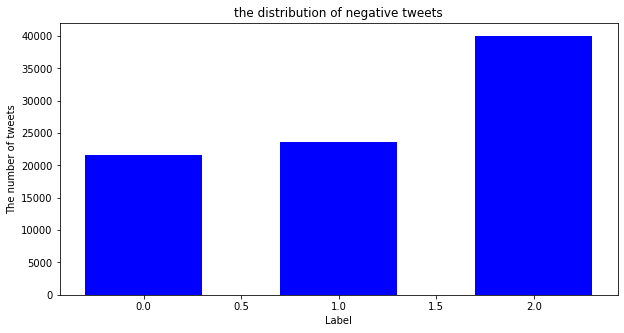

In [153]:
count0 = count1 = count2 = 0 
for num in pred_neg_labels2:
  if num == 0:
    count0 += 1
  if num == 1:
    count1 += 1
  else:
    count2 += 1

fig = plt.figure(figsize = (10, 5))
plt.bar([0, 1, 2], [count0, count1, count2], color ='blue', width = 0.6)
plt.title("the distribution of negative tweets")
plt.xlabel("Label")
plt.ylabel("The number of tweets")